In [2]:
import pickle

# Cargar la variable desde el archivo pickle
with open('variables.pkl', 'rb') as file:
    data = pickle.load(file)


FileNotFoundError: ignored

In [ ]:
#Checking data types of each variable
data.dtypes

NameError: ignored

In [ ]:
data['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

Encoding the outcome variable: The outcome we are looking at is whether the patient gets readmitted to the hospital within 30 days or not. The variable actually has < 30, > 30 and No Readmission categories. To reduce our problem to a binary classification, we combined the readmission after 30 days and no readmission into a single category:

In [ ]:
data['readmitted'] = data['readmitted'].replace('>30', 0)
data['readmitted'] = data['readmitted'].replace('<30', 1)
data['readmitted'] = data['readmitted'].replace('NO', 0)

In [ ]:
data['readmitted'].value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

In [ ]:
#Reviewing the data
#patient_nbr: Unique identifier of a patient, keep only the first record of each patient
data_0 = data.loc[data['readmitted'] == 0]
data_1 = data.loc[data['readmitted'] == 1]
data_0 = data_0.drop_duplicates(subset='patient_nbr', keep='first')
data = pd.concat([data_0, data_1], ignore_index=True)
#encounter_id: Unique identifier of an encounter, remove both columns
data = data.drop(columns=['encounter_id', 'patient_nbr'])
#admission_type_id: Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available. Remove because I still don´t know how to process this data type
#discharge_disposition_id: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available. Remove because I still don´t know how to process this data type
#admission_source_id: Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital. Remove because I still don´t know how to process this data type
data = data.drop(columns=['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])

(80522, 45)
0    69165
1    11357
Name: readmitted, dtype: int64


Text(0.5, 1.0, 'Distrinution of Readmission')

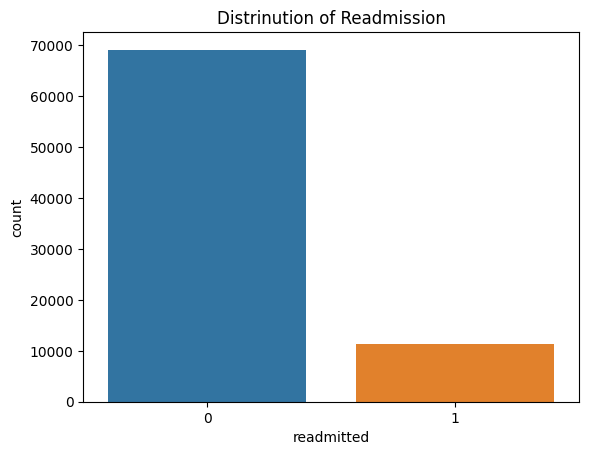

In [ ]:
print(data.shape)
print(data['readmitted'].value_counts())
# Distribution of Readmission 
import seaborn as sns
sns.countplot(x=data["readmitted"]).set_title('Distrinution of Readmission')

In [ ]:
numerics = ['int64']
X = data.select_dtypes(include=numerics).drop(columns=['readmitted'])
y = data['readmitted']
#Perform a sampling to divide between train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())
X.dtypes

(56365, 8) (56365,)
(24157, 8) (24157,)
0    48367
1     7998
Name: readmitted, dtype: int64
0    20798
1     3359
Name: readmitted, dtype: int64


time_in_hospital      int64
num_lab_procedures    int64
num_procedures        int64
num_medications       int64
number_outpatient     int64
number_emergency      int64
number_inpatient      int64
number_diagnoses      int64
dtype: object

In [ ]:
#Since our target variable is having class imbalance problem, So will use SMOTE technique to resolve it
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=20)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train)))

Original dataset shape Counter({0: 48367, 1: 7998})
New dataset shape Counter({0: 48367, 1: 48367})


In [ ]:
#Checking shape and displaying first 10 rows of X_train
print(X_train.shape)
X_train.head(10).T

(96734, 8)


,0,1,2,3,4,5,6,7,8,9
time_in_hospital,5,3,5,1,6,2,10,3,1,2
num_lab_procedures,17,1,48,38,40,41,46,72,41,24
num_procedures,1,1,2,1,4,1,3,2,2,3
num_medications,22,18,26,12,16,14,12,12,7,18
number_outpatient,1,0,6,2,0,0,0,0,0,0
number_emergency,1,0,0,0,0,0,0,1,0,0
number_inpatient,0,0,1,0,0,0,0,0,0,0
number_diagnoses,4,5,9,4,9,9,8,6,9,9


In [ ]:
from tensorflow.keras import utils 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_trainN = scaler.fit_transform(X_train)
X_testN = scaler.transform(X_test)

In [ ]:
#Red neuronal más simple
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

input_dim = X_train.shape[1]

# Definir la arquitectura del modelo
model = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,)),  # Capa oculta con 16 neuronas
    Dense(1, activation='sigmoid')  # Capa de salida con una neurona (predicción binaria)
])

model.summary()

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
#Modelo RNN LSTM
# Definir el modelo RNN LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[1])))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18688     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,753
Trainable params: 18,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Entrenar el modelo
# Preparar los datos de entrada en el formato adecuado para RNN --> [n_samples,n_times,n_features]
X_trainRnn = np.reshape(X_trainN, (X_trainN.shape[0], 1, X_trainN.shape[1]))
X_testRnn = np.reshape(X_testN, (X_testN.shape[0], 1, X_testN.shape[1]))
model.fit(X_trainRnn, y_train, batch_size=32, epochs=64, validation_data=(X_testRnn, y_test))

Epoch 1/64
3023/3023 [==============================] - 17s 5ms/step - loss: 0.6338 - accuracy: 0.6279 - val_loss: 0.6272 - val_accuracy: 0.6989
Epoch 2/64
3023/3023 [==============================] - 13s 4ms/step - loss: 0.6280 - accuracy: 0.6327 - val_loss: 0.6067 - val_accuracy: 0.7184
Epoch 3/64
3023/3023 [==============================] - 12s 4ms/step - loss: 0.6267 - accuracy: 0.6344 - val_loss: 0.6345 - val_accuracy: 0.6657
Epoch 4/64
3023/3023 [==============================] - 13s 4ms/step - loss: 0.6257 - accuracy: 0.6353 - val_loss: 0.6204 - val_accuracy: 0.6964
Epoch 5/64
3023/3023 [==============================] - 13s 4ms/step - loss: 0.6249 - accuracy: 0.6362 - val_loss: 0.6248 - val_accuracy: 0.6733
Epoch 6/64
3023/3023 [==============================] - 13s 4ms/step - loss: 0.6237 - accuracy: 0.6367 - val_loss: 0.6358 - val_accuracy: 0.6527
Epoch 7/64
3023/3023 [==============================] - 13s 4ms/step - loss: 0.6226 - accuracy: 0.6393 - val_loss: 0.6154 - val_ac

In [ ]:
# Evaluar el modelo con los datos de prueba, por el momento no lo quiero ya que es engañoso
#Es alto porque la mayoría de datos son '0' pero predice mal los readmitidos
loss, accuracy = model.evaluate(X_testRnn, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)

755/755 [==============================] - 2s 2ms/step - loss: 0.6063 - accuracy: 0.7030
Loss: 0.606285810470581
Accuracy: 0.7030260562896729


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Obtener las probabilidades de clase del modelo en los datos de prueba
y_pred_prob = model.predict(X_testRnn)

# Aplicar umbral de decisión para obtener predicciones de clase
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Obtener las métricas de clasificación para cada clase
classification_rep = classification_report(y_test, y_pred)

print("Matriz de confusión:")
print(cm)
print("\nReporte de clasificación:")
print(classification_rep)

755/755 [==============================] - 2s 2ms/step
Matriz de confusión:
[[15265  5533]
 [ 1641  1718]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81     20798
           1       0.24      0.51      0.32      3359

    accuracy                           0.70     24157
   macro avg       0.57      0.62      0.57     24157
weighted avg       0.81      0.70      0.74     24157

